In [15]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Tree Based Models

from operator import itemgetter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

# Linear Regression Based Models

from sklearn.linear_model import ElasticNet, HuberRegressor, LinearRegression, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor

# Metrics

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Parallel

from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from dask_ml.model_selection import GridSearchCV

from feature_selection_helper import norm_cols

import warnings
warnings.filterwarnings("ignore")


In [2]:
stk = pd.read_csv("../data/train_processed_upsampled.csv")
stk.head()

,stroke_in_2018,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
X = stk.drop(labels="stroke_in_2018", axis=1).reset_index(drop=True)
y = stk["stroke_in_2018"].reset_index(drop=True)

In [17]:
X_norm = X.copy()
norm_cols(X_norm, ["average_blood_sugar", "BMI", "age_corr"])

In [18]:
X_norm.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0.051093,0.298718,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.204796,0.219231,0.236111,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.071513,0.369231,0.527778,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.230342,0.564103,0.569444,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.046560,0.171795,0.194444,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
stk_test = pd.read_csv("../data/test_processed_feature_engineered.csv")
stk_test.head()

,id,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,33327,76.05,33.4,36,1,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0
1,839,73.77,30.1,40,1,0,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
2,11127,62.95,30.8,59,1,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,20768,68.81,36.5,33,1,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
4,37774,122.89,30.8,22,1,0,1,0,0,1,...,1,0,1,0,0,0,1,0,0,0


In [26]:
X_test = stk_test.copy()
X_test_norm = X_test.copy()
norm_cols(X_test_norm, ["average_blood_sugar", "BMI", "age_corr"])

In [27]:
X_test_norm.head()

,id,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,33327,0.075016,0.256410,0.402439,1,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0
1,839,0.064606,0.216117,0.451220,1,0,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
2,11127,0.015204,0.224664,0.682927,1,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,20768,0.041960,0.294261,0.365854,1,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
4,37774,0.288878,0.224664,0.231707,1,0,1,0,0,1,...,1,0,1,0,0,0,1,0,0,0


In [3]:
linear_based_models = {
    "en": ElasticNet(),
    "hr": HuberRegressor(),
    "lr": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "sgd": SGDRegressor(), 
    "pa": PassiveAggressiveRegressor()
}

tree_based_models = {
    "dt": DecisionTreeRegressor(),
    "rf": RandomForestRegressor(),
    "ada": AdaBoostRegressor(),
    "gb": GradientBoostingRegressor(),
    "et": ExtraTreesRegressor(),
    "xgb": XGBRegressor()
}

tree_model_best_features = [
    'BMI',
    'high_BMI',
    'average_blood_sugar',
    'age_corr',
    'job_status_corr_government'
]

linear_model_selected_features = [
    'low_sugar',
    'job_status_corr_government',
    'medium_sugar',
    'smoker_status_non_smoker',
    'high_BMI',
    'child',
    'BMI',
    'age_corr',
    'married_0',
    'medium_BMI',
    'smoker_status_quit',
    'adult',
    'job_status_corr_unemployed',
    'job_status_corr_business_owner',
    'job_status_corr_parental_leave',
    'has_smoked',
    'elderly',
    'job_status_corr_private_sector',
    'smoker_status_active_smoker',
    'very_high_BMI',
    'low_BMI',
    'high_BP_1',
    'very_high_sugar',
    'high_BP_0',
    'senior',
    'heart_condition_detected_2017_1',
    'heart_condition_detected_2017_0',
    'living_area_corr_remote',
    'average_blood_sugar',
    'high_sugar',
    'married_1',
    'living_area_corr_city'
]

features = [
    ("tree", tree_model_best_features),
    ("linear", linear_model_selected_features)
]


In [4]:
def get_cv_score(clf, X, y, kf):
    cv_scores = []
    with parallel_backend("dask"):
        for _, (train_index, test_index) in enumerate(kf.split(X, y)):
            train_X, train_y = X.loc[train_index], y[train_index] 
            # up sampling the train data
#             train_X, train_y = smote.fit_sample(train_X, train_y)
            test_X, test_y = X.loc[test_index], y[test_index]

            clf.fit(train_X, train_y)
            y_pred = clf.predict(test_X)
            score = roc_auc_score(test_y, y_pred)
            cv_scores.append(score)
        return np.mean(cv_scores)

In [5]:
from copy import deepcopy

class StackingRegressor:
    def __init__(self, models, second_model, features):
        self.models = models
        self.feature_models = []
        self.second_model = second_model
        self.features = features
    
    def _generate_f_features(self, X):
        f_features = np.zeros((X.shape[0], len(self.features) * len(self.models)))
        for num, features in enumerate(self.features * len(self.models)):
            model = self.feature_models[num]
            f_features[:, num] = model.predict(X.loc[:, features[1]])
        return f_features
    
    def fit(self, X, y):
        # generate multiple trained models with different features
        for model in self.models:
            for feature in self.features:
                model.fit(X.loc[:, feature[1]], y)
                self.feature_models.append(deepcopy(model))
        f_features = self._generate_f_features(X)
        self.second_model.fit(f_features, y)
    
    def predict(self, X):
        f_features = self._generate_f_features(X)
        return self.second_model.predict(f_features)

In [40]:
models = [
    GradientBoostingRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), 
    Lasso(), LinearRegression(), Ridge()
]

In [48]:
models2 = [
    GradientBoostingRegressor(), RandomForestRegressor(), 
    Lasso(), LinearRegression()
]

In [49]:
sr = StackingRegressor(models2, GradientBoostingRegressor(), features)
sr

In [50]:
sr.fit(X_norm, y)

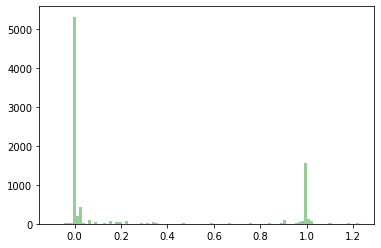

In [51]:
y_pred = sr.predict(X_test_norm)

sns.distplot(y_pred, kde = False, bins = 100, color = "green")

In [47]:
# models = [
#     GradientBoostingRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), 
#     Lasso(), LinearRegression(), Ridge()
# ]

submission = pd.DataFrame({
    "id": stk_test["id"],
    "stroke_in_2018": y_pred
})
submission.to_csv("../submission/")

,id,stroke_in_2018
0,33327,-0.000004
1,839,1.004425
2,11127,-0.000004
3,20768,-0.000026
4,37774,-0.000004
5,4283,0.011798
6,13832,0.999509
7,4579,-0.000004
8,26781,0.999999
9,17196,0.998605


In [44]:
pd.Series(y_pred).unique()
pd.Series(y_pred).value_counts()

-0.000004    3539
-0.000026     387
-0.000351     152
-0.000338     129
 1.000024     125
 0.000014     118
 0.999499     116
 0.000028     108
 0.999551      79
 0.000698      71
 0.000446      71
 0.798574      69
 0.999999      67
 1.000076      59
-0.000176      51
 0.017367      49
-0.000157      48
 1.003188      47
-0.000167      46
 0.009946      46
 0.000420      44
-0.000055      44
 0.999473      43
 0.999822      38
 0.000137      37
 0.804015      37
 0.999929      36
 1.000067      35
 0.999770      34
 0.958273      34
             ... 
 0.127908       1
 0.960919       1
-0.026793       1
 0.498008       1
 0.776367       1
 1.074160       1
 0.076017       1
 0.439844       1
 0.000119       1
 0.983806       1
 0.688940       1
 0.002975       1
 1.006010       1
 1.023795       1
 0.000104       1
 0.995713       1
 0.227513       1
 0.238301       1
-0.010734       1
 0.001357       1
 0.890826       1
 0.789803       1
 1.043419       1
 0.629657       1
 0.007449 